In [2]:
import os
import sys
import platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets
import sklearn as sk
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

In [3]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

print("you're using device :", device)

Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.5.1

Python 3.11.6 (main, Nov 12 2024, 15:30:44) [Clang 15.0.0 (clang-1500.3.9.4)]
Pandas 2.2.3
Scikit-Learn 1.5.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps
you're using device : mps


In [4]:
TRAIN_DATA_PATH = "/Users/roberto/Desktop/FDS-Final/dataframe/train"
TEST_DATA_PATH = "/Users/roberto/Desktop/FDS-Final/dataframe/test"

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations

        # Define the mapping from string labels to numeric labels
        self.label_map = {
            "TSLA": 0,  # Tesla
            "KO": 1,    # Coca-Cola
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        # Extract the label from the filename
        label_str = image_path.split("/")[-1].split("_")[0]  # e.g., "TSLA" or "KO"
        if label_str not in self.label_map:
            raise ValueError(f"Unknown label: {label_str} in file {image_path}")
        
        label = self.label_map[label_str]  # Map the string label to a numeric label
        
        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations and np.random.rand() > 0.5:
            image = self.augmentations(image)

        return image, label

In [7]:
def get_images_paths(folder_path=None):
    if folder_path is None:
        raise ValueError("folder_path cannot be None. It must be TRAIN_DATA_PATH or TEST_DATA_PATH.")

    if folder_path != TRAIN_DATA_PATH and folder_path != TEST_DATA_PATH:
        raise ValueError("folder_path must be TRAIN_DATA_PATH or TEST_DATA_PATH.")

    images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"):
                images.append(os.path.join(root, file))
    return images

In [8]:
def get_train_valid_loader(train_size=0.8, batch_size=32, num_workers=0):

    images_paths = get_images_paths(TRAIN_DATA_PATH)
    np.random.shuffle(images_paths)
    train_images_paths = images_paths[:int(len(images_paths) * train_size)]
    valid_images_paths = images_paths[int(len(images_paths) * train_size):]

    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    augumentation_transform = transforms.Compose([
        transforms.RandomRotation(3),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.001, contrast=0.001, saturation=0.001, hue=0)
    ])

    train_dataset = Dataset(train_images_paths, transform=base_transform, augmentations=augumentation_transform)
    valid_dataset = Dataset(valid_images_paths, transform=base_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, valid_loader

In [9]:
def get_test_loader(batch_size=32, num_workers=0, shuffle=True):
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_paths = get_images_paths(TEST_DATA_PATH)
    test_dataset = Dataset(image_paths, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return test_loader

In [10]:
def count_images_per_class(folder_path):
    images = get_images_paths(folder_path)
    label_map = {
        'TSLA': 0,
        'KO': 1,
        # aggiungi altre etichette se necessario
    }
    labels = [label_map[image.split("/")[-1].split("_")[0]] for image in images]
    return pd.Series(labels).value_counts().sort_index()


In [11]:
count_images_per_class(TRAIN_DATA_PATH)

0    915
1    917
Name: count, dtype: int64

In [12]:
count_images_per_class(TEST_DATA_PATH)

0    41
1    41
Name: count, dtype: int64

In [13]:
train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

In [14]:
import os

# Mappa delle classi stringhe a numeri
label_map = {
    'tsla': 0,
    'ko': 1,
    # Aggiungi altre classi se necessario
}

def plot_images_per_class(loader, num_images=5):
    class_1_images = {"images": [], "labels": []}
    class_2_images = {"images": [], "labels": []}

    for images, labels in loader:
        for image_path, label in zip(images, labels):
            # Estrai la parte della label dalla cartella in cui si trova l'immagine
            label_str = os.path.basename(os.path.dirname(image_path))  # Questo ottiene la cartella
            label_str = label_str.lower()  # Normalizza a minuscolo per evitare problemi di maiuscole/minuscole
            
            # Usa la mappatura per ottenere l'etichetta numerica
            if label_str in label_map:
                label = label_map[label_str]
            else:
                print(f"Errore: label '{label_str}' non trovata nella mappatura.")
                continue

            # Classifica e memorizza le immagini nelle rispettive classi
            if label == 0 and len(class_1_images["images"]) < num_images:
                class_1_images["images"].append(image_path)
                class_1_images["labels"].append(label)
            elif label == 1 and len(class_2_images["images"]) < num_images:
                class_2_images["images"].append(image_path)
                class_2_images["labels"].append(label)

    # Qui puoi inserire il codice per visualizzare le immagini

    plt.show()

In [15]:
class ResNet34Pretrained(nn.Module):
    def __init__(self):
        super(ResNet34Pretrained, self).__init__()
        self.model = torchvision.models.resnet34(weights='DEFAULT', progress=False)

        # for param in self.model.parameters():
        #     param.requires_grad = False

        nr_filters = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(nr_filters, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.LogSoftmax(dim=1)
        )
        self.model = self.model.to(device)

    def forward(self, x):
        return self.model(x)

model = ResNet34Pretrained()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [16]:
# %%script false --no-raise-error
checkpoint_dir = "/Users/roberto/Desktop/FDS-Final/checkpoints"
def training(train_loader=None, valid_loader=None, model=None, device=None, num_epochs=25):
    if train_loader is None:
        raise ValueError("train_loader cannot be None.")
    if valid_loader is None:
        raise ValueError("valid_loader cannot be None.")
    if model is None:
        raise ValueError("model cannot be None.")
    if device is None:
        raise ValueError("device cannot be None.")

    train_losses = []
    valid_losses = []

    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = .0
        train_acc = .0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, preds = torch.max(output, 1)
            train_acc += (preds == target).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        train_acc = train_acc / len(train_loader.dataset)
        train_accs.append(train_acc)

        model.eval()
        valid_loss = .0
        valid_acc = .0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                _, preds = torch.max(output, 1)
                valid_acc += (preds == target).sum().item()

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        valid_acc = valid_acc / len(valid_loader.dataset)
        valid_accs.append(valid_acc)

        print(f"[{epoch+1}/{num_epochs}]: ")
        print(f"    Train Loss: {train_loss:.4f} -- Valid Loss: {valid_loss:.4f}")
        print(f"    Train Acc:  {train_acc:.4f} -- Valid Acc:  {valid_acc:.4f}")

    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), f"{checkpoint_dir}/model_epoch_{epoch+1}.pth")

# Dopo il ciclo for, salva lo stato finale del modello in un file, non nella directory
    torch.save(model.state_dict(), f"{checkpoint_dir}/model_final.pth")

    return train_losses, valid_losses, train_accs, valid_accs



In [17]:
# %%script false --no-raise-error
train_losses, valid_losses, train_accs, valid_accs = training(train_loader, valid_loader, model, device, num_epochs=61)

[1/61]: 
    Train Loss: 0.0073 -- Valid Loss: 0.0020
    Train Acc:  0.9017 -- Valid Acc:  0.9809
[2/61]: 
    Train Loss: 0.0052 -- Valid Loss: 0.0086
    Train Acc:  0.9468 -- Valid Acc:  0.9264
[3/61]: 
    Train Loss: 0.0029 -- Valid Loss: 0.0024
    Train Acc:  0.9693 -- Valid Acc:  0.9673
[4/61]: 
    Train Loss: 0.0016 -- Valid Loss: 0.0015
    Train Acc:  0.9802 -- Valid Acc:  0.9837
[5/61]: 
    Train Loss: 0.0015 -- Valid Loss: 0.0003
    Train Acc:  0.9877 -- Valid Acc:  0.9946
[6/61]: 
    Train Loss: 0.0023 -- Valid Loss: 0.0052
    Train Acc:  0.9788 -- Valid Acc:  0.9591
[7/61]: 
    Train Loss: 0.0020 -- Valid Loss: 0.0004
    Train Acc:  0.9788 -- Valid Acc:  1.0000
[8/61]: 
    Train Loss: 0.0013 -- Valid Loss: 0.0006
    Train Acc:  0.9850 -- Valid Acc:  0.9891
[9/61]: 
    Train Loss: 0.0006 -- Valid Loss: 0.0027
    Train Acc:  0.9939 -- Valid Acc:  0.9782
[10/61]: 
    Train Loss: 0.0014 -- Valid Loss: 0.0004
    Train Acc:  0.9829 -- Valid Acc:  0.9973
[11/61]: 

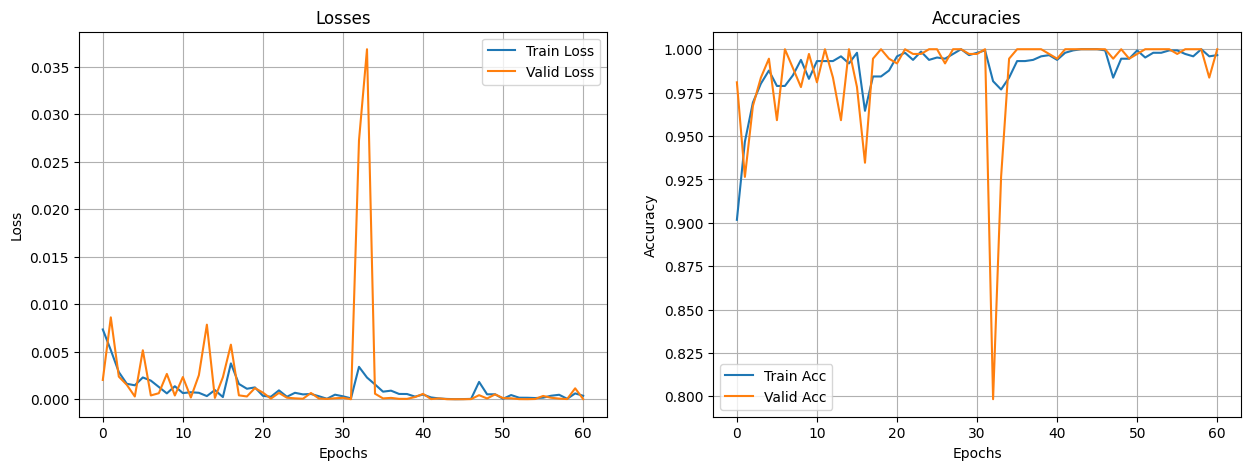

In [18]:
# %%script false --no-raise-error

def plots_curves(train_loss, valid_loss, train_acc, valid_acc):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(train_loss, label="Train Loss")
    axes[0].plot(valid_loss, label="Valid Loss")
    axes[0].set_title("Losses")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid()
    axes[1].plot(train_acc, label="Train Acc")
    axes[1].plot(valid_acc, label="Valid Acc")
    axes[1].set_title("Accuracies")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid()

    plt.show()

plots_curves(train_losses, valid_losses, train_accs, valid_accs)

In [19]:
#%%script false --no-raise-error

def testing(test_loader=None, model=None, device=None):
    if test_loader is None:
        raise ValueError("test_loader cannot be None.")
    if model is None:
        raise ValueError("model cannot be None.")
    if device is None:
        raise ValueError("device cannot be None.")

    model.eval()
    test_loss = .0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    return test_loss, all_preds, all_targets

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_9971/1026075761.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/rober

Test Loss: 0.0000
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000


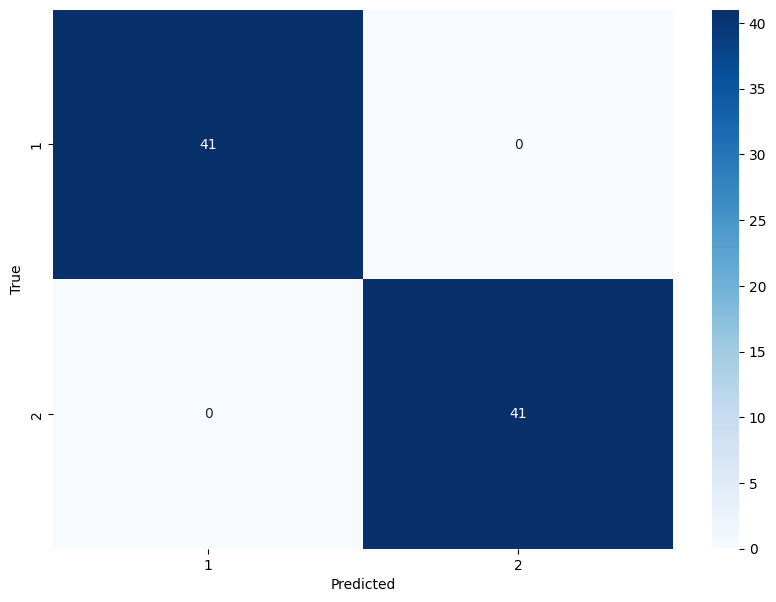

In [21]:
#%%script false --no-raise-error

model = ResNet34Pretrained()
model.load_state_dict(torch.load("/Users/roberto/Desktop/FDS-Final/checkpoints/model_final.pth"))
model = model.to(device)

test_loss, all_preds, all_targets = testing(test_loader, model, device)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_targets, all_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

class_names = ["1", "2"]
plot_confusion_matrix(all_targets, all_preds, class_names)